<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/MINE_0219.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MINE

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [64]:
data_size = 20000
cor = [0.5, 1, 1.5, 2.5, 3]

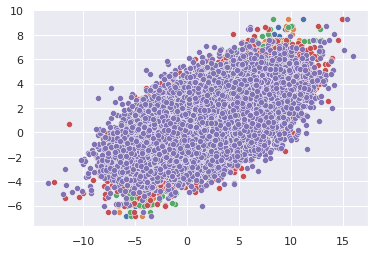

In [191]:
y= np.random.normal(1,2,data_size)
x = np.zeros((data_size,6))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

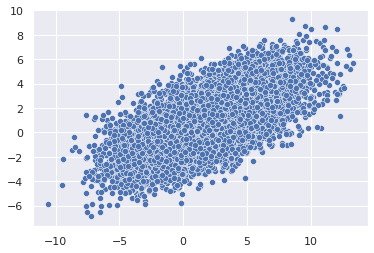

In [192]:
for i in range(200):
    os = i*100
    x[os:os+100,4] = y[os:os+100] + np.random.normal(1,1+(i/100),100)
    x[os:os+100,5] = i
sns.scatterplot(x=x[:,4],y=y)

In [193]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [258]:
mi_scores = make_mi_scores(pd.DataFrame(x,columns=['x0','x1','x2','x3','x4','ix']), y, discrete_features="auto")
print(mi_scores)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


x0    1.431561
x1    0.807808
x2    0.517238
x4    0.334460
x3    0.259183
ix    0.007143
Name: MI Scores, dtype: float64


In [195]:
for i in range(200):
    os = i*100
    mi_scores = make_mi_scores(pd.DataFrame(x[os:os+100,4],columns=['x4']), y[os:os+100], discrete_features="auto")
    print(i, mi_scores)

0 x4    0.797909
Name: MI Scores, dtype: float64
1 x4    0.811538
Name: MI Scores, dtype: float64
2 x4    0.867166
Name: MI Scores, dtype: float64
3 x4    0.433704
Name: MI Scores, dtype: float64
4 x4    0.864698
Name: MI Scores, dtype: float64
5 x4    0.655201
Name: MI Scores, dtype: float64
6 x4    0.744298
Name: MI Scores, dtype: float64
7 x4    0.731306
Name: MI Scores, dtype: float64
8 x4    0.809324
Name: MI Scores, dtype: float64
9 x4    0.859251
Name: MI Scores, dtype: float64
10 x4    0.707572
Name: MI Scores, dtype: float64
11 x4    0.730468
Name: MI Scores, dtype: float64
12 x4    0.609032
Name: MI Scores, dtype: float64
13 x4    0.830942
Name: MI Scores, dtype: float64
14 x4    0.640426
Name: MI Scores, dtype: float64
15 x4    0.709642
Name: MI Scores, dtype: float64
16 x4    0.742484
Name: MI Scores, dtype: float64
17 x4    0.646277
Name: MI Scores, dtype: float64
18 x4    0.600644
Name: MI Scores, dtype: float64
19 x4    0.585778
Name: MI Scores, dtype: float64
20 x4    0

(20000, 6)
(20000, 1)


100%|██████████| 300/300 [00:07<00:00, 41.67it/s]


tensor([ 1.4169e+00,  8.0757e-01,  5.2407e-01,  2.5850e-01,  3.4160e-01,
        -1.5688e-04], grad_fn=<CopySlices>)


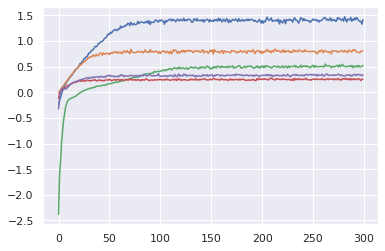

In [259]:
from tqdm import tqdm

H=20
n_epoch = 300
minibatch = 10000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  

model = [Net() for i in range(x.shape[1])]
optimizer = [torch.optim.Adam(model[i].parameters(), lr=0.01) for i in range(x.shape[1])]

plot_loss = []

y=y.reshape(-1,1)
print(x.shape)
print(y.shape)

for epoch in tqdm(range(n_epoch)):
    back_loss = torch.zeros(6)
    s = np.random.choice(x.shape[0],minibatch)
    for i in range(x.shape[1]):
        x_sample = Variable(torch.from_numpy(x[s,i].reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)    
        ret = torch.mean(model[i](x_sample, y_sample)) - torch.log(torch.mean(torch.exp(model[i](x_sample, y_shuffle))))
        loss = - ret  # maximize
        model[i].zero_grad()
        loss.backward()
        optimizer[i].step()
        back_loss[i] = ret

    plot_loss.append(back_loss.data.numpy())


    #back_loss = loss

print('')
print(back_loss)

plot_loss = np.asarray(plot_loss)

plt.plot(plot_loss[:,0])
plt.plot(plot_loss[:,1])
plt.plot(plot_loss[:,2])
plt.plot(plot_loss[:,3])
plt.plot(plot_loss[:,4])

In [285]:
from tqdm import tqdm

H=20
n_epoch = 1200
minibatch = 10000

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        
        for i in range(self.input_dim): 
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y))
            h.append(self.fc3[i](h0))
        return torch.cat(h, dim=1)  

model = Net(x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

plot_loss = []
di = []
y=y.reshape(-1,1)
print(x.shape)
print(y.shape)

for epoch in tqdm(range(n_epoch)):
    i = epoch%100
    s = [*range(i*200,i*200+200)]  
    #s = np.random.choice(x.shape[0],minibatch)
    x_sample = Variable(torch.from_numpy(x[s,:]).type(torch.FloatTensor), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)    
    p_xy = model(x_sample, y_sample)
    p_x_y = model(x_sample, y_shuffle)
    ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
    loss = - ret  # maximize

    model.zero_grad()
    loss.mean().backward()
    optimizer.step()

    plot_loss.append(-loss.data.numpy())

    dx = torch.autograd.grad(ret[4], x_sample[-1,5])
    print(dx)

    di.append(torch.mean(x_sample.grad,0).data.numpy())

    #back_loss = loss
    #if i == 99:
    #    print(loss[4])

print(x_sample.grad[-1,:])

plot_loss = np.asarray(plot_loss)
di = np.asarray(di)
print(mi_scores)
print(np.mean(plot_loss[200:,:],0))
#print(np.mean(di[200:,0],0))

#print(x_sample.grad)

plt.plot(plot_loss[:,0:5])
plt.show()




(20000, 6)
(20000, 1)


  0%|          | 0/1200 [00:00<?, ?it/s]


RuntimeError: ignored

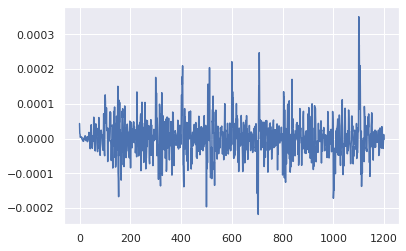

In [272]:
plt.plot(di[:,4])
plt.show()

+ 편미분 Test

In [28]:
def uc(a,b):
    return a*b[0] + b[1]

In [42]:
x = torch.tensor(100.0, requires_grad=True)
t = torch.tensor(2.0, requires_grad=True)
print(x)
print(t)
u = x**2 * t
print(u)
# 1st derivatives
#dt = torch.autograd.grad(u, t)[0]
#print(dt)
dx = torch.autograd.grad(u, x,create_graph=True)[0]
print(dx)
# 2nd derivatives (higher orders require `create_graph=True`)
ddx = torch.autograd.grad(dx, x)[0]
print(ddx)

tensor(100., requires_grad=True)
tensor(2., requires_grad=True)
tensor(20000., grad_fn=<MulBackward0>)
tensor(400., grad_fn=<MulBackward0>)
tensor(4.)


In [283]:
tx = torch.tensor([*range(200)],dtype=float, requires_grad=True)
ty = tx * torch.normal(1.0,0.5,size=(200,))
dx = torch.autograd.grad(torch.sum(ty), tx)[0]
print(np.mean(dx.tolist()))

0.9984062308073044


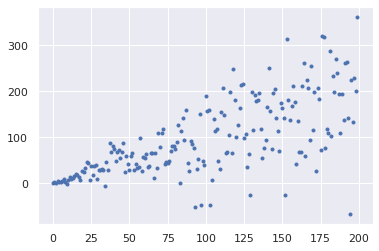

In [284]:
plt.plot(ty.detach().numpy(),'.')

In [275]:
a = torch.rand(10, requires_grad=True)
b = torch.rand(10, requires_grad=True)

output = (2 * a).sum()

c = torch.autograd.grad(output, (a, b),allow_unused=True)
c

(tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]), None)

In [253]:
aa = np.random.rand(3,3)
aa

array([[0.34207617, 0.82441226, 0.64928929],
       [0.252307  , 0.11404317, 0.7796202 ],
       [0.40402305, 0.17394293, 0.23767829]])

In [256]:
aa[:,[1,-1]]

array([[0.82441226, 0.64928929],
       [0.11404317, 0.7796202 ],
       [0.17394293, 0.23767829]])